In [2]:

import sys, os  
import pandas as pd  
import numpy as np  
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.losses import categorical_crossentropy    
from keras.regularizers import l2  
from keras.utils import np_utils 
from keras.models import load_model

In [3]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


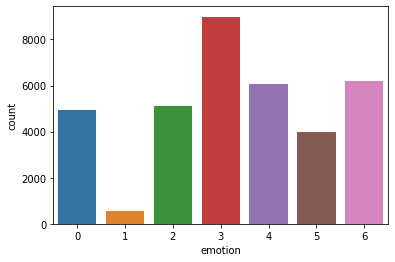

In [8]:
sns.countplot(df.emotion)
plt.show()

In [9]:
np.sqrt(len(df.pixels[0].split(' ')))

48.0

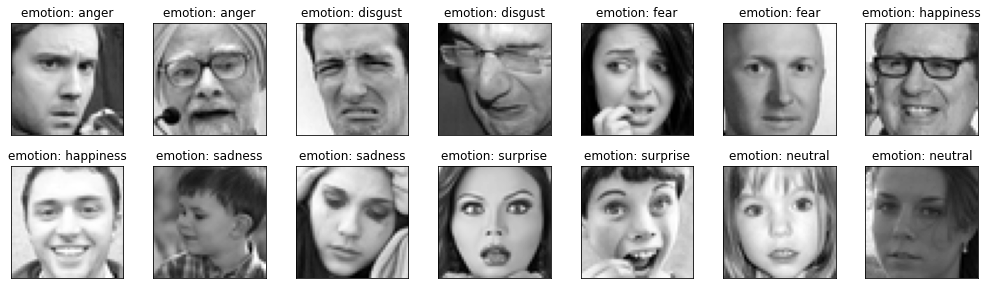

In [10]:
fig = plt.figure(num=None, figsize=(14,14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(2):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('emotion: {}'.format(emotion_label_to_text[label]))
        plt.tight_layout()

In [11]:
X_train, y_train, X_test, y_test = [], [], [], []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [12]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

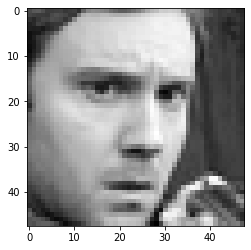

In [13]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48), cmap = 'gray')

In [14]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [15]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_train.shape

(28709, 48, 48, 1)

In [16]:
#chuyen label ve dang one hot
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1.0/255
    )
datagen.fit(X_train)
batch_size = 64 

In [18]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

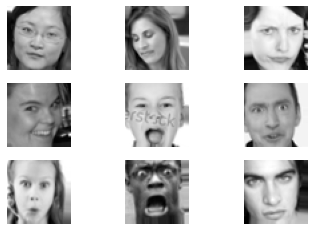

In [19]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

In [20]:
model = Sequential()

In [21]:
#block1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

In [22]:
#block2
model.add(Conv2D(128, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

In [23]:
#block3
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

In [24]:
#block4
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

In [25]:
#block5
model.add(Conv2D(512, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

In [26]:
model.add(Flatten())

In [27]:
model.add(Dense(1024, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation= 'softmax'))

In [28]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [29]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")

In [30]:
history = model.fit_generator(train_flow, 
          epochs= 32, 
          validation_data=test_flow)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/32
449/449 [==============================] - 82s 156ms/step - loss: 1.8824 - accuracy: 0.2488 - val_loss: 1.8355 - val_accuracy: 0.2413
Epoch 2/32
449/449 [==============================] - 69s 153ms/step - loss: 1.6007 - accuracy: 0.3684 - val_loss: 1.7487 - val_accuracy: 0.3566
Epoch 3/32
449/449 [==============================] - 69s 153ms/step - loss: 1.4275 - accuracy: 0.4506 - val_loss: 1.3708 - val_accuracy: 0.4815
Epoch 4/32
449/449 [==============================] - 69s 154ms/step - loss: 1.3214 - accuracy: 0.4944 - val_loss: 1.3199 - val_accuracy: 0.4990
Epoch 5/32
449/449 [==============================] - 69s 154ms/step - loss: 1.2701 - accuracy: 0.5209 - val_loss: 1.3175 - val_accuracy: 0.5194
Epoch 6/32
449/449 [==============================] - 69s 153ms/step - loss: 1.2214 - accuracy: 0.5449 - val_loss: 1.4685 - val_accuracy: 0.4957
Epoch 7/32
449/449 [==============================] - 69s 153ms/step - loss: 1.1952 - accuracy: 0.5520 - val_loss: 1.1833 - val_ac

<Figure size 432x288 with 0 Axes>

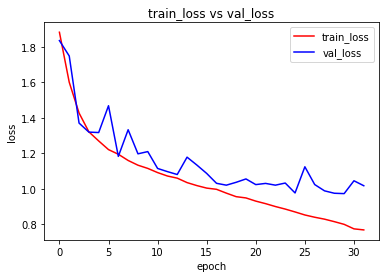

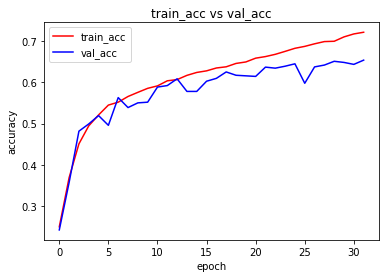

<Figure size 432x288 with 0 Axes>

In [31]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [32]:
model.save('modelFER2013.h5')
model.save_weights('modelFER2013_weights.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/modelFER2013.h5')

In [ ]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 4s 32ms/step - loss: 1.0141 - accuracy: 0.6514
Test Loss 1.0141184329986572
Test Acc: 0.6514349579811096


113/113 [==============================] - 4s 28ms/step


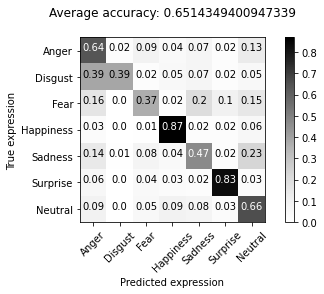

In [ ]:
classes = np.array(("Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise", "Neutral"))
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [ ]:
def predict_by_model(i):
  sample = X_test[i]/255.
  sample = sample.reshape(1,48,48,1)
  pred_cls = model.predict(sample)
  plt.imshow(sample.reshape(48,48), cmap='gray')
  plt.show()
  print("{}, Predict:{}".format(emotion_label_to_text[np.argmax(y_test[i], axis=0)], emotion_label_to_text[int(np.argmax(pred_cls, axis=1))]))

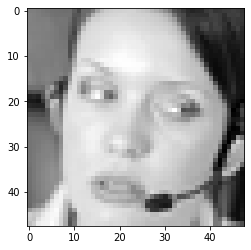

anger, Predict:fear


In [ ]:
import random
i = random.randint(0,len(X_test)+1)
predict_by_model(i)